# TDs
* Make coef plot
* Make plots for behavior
* Run behavior model with all three tasks

# Setup

In [1]:
debug = False

make_ridge_models = True
n_gridder_repeats = 100
regression_type = 'repeatedCV'  # 'regular'  # 'ridge', 'repeatedCV'

make_boot_models = False
n_boot_models = 100

## Imports

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
from regressors import stats as rstats
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import ttest_ind_from_stats, ttest_1samp
from Functions import get_category_dict, get_category_from_feature
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [3]:
# import regressors
# from scipy import stats as sstats
# import statsmodels.api as sm
# from sklearn.compose import TransformedTargetRegressor
# from sklearn.model_selection import RepeatedKFold
# import sklearn.linear_model as sklin
# import sklearn.metrics as skmet

In [4]:
from Functions import get_param_names, get_ages_cols, get_category_dict, get_category_from_feature

## Directories etc.

In [5]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

## Get data

In [6]:
category_dict = get_category_dict()

In [7]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [8]:
category_dict = get_category_dict()
ages_cols = get_ages_cols()

param_cols = list(set([c for c in all_data.columns for p in get_param_names()
                       if (p in c) and ('ps_p_switch' not in c) and ('ps_p_reward' not in c)]))
print(param_cols)

behav_cols = []
for cat in ['RT', 'ACC', 'WS', 'LS', 'Delay']:
    behav_cols += category_dict[cat]
behav_cols = [c for c in behav_cols if ('RTsd' not in c) and ('ps_LWS' not in c) and ('bf_prew' not in c)]
print(behav_cols)

['rl_K', 'rl_log_nalpha', 'ps_1_over_beta', 'rl_epsilon_1_over_beta', 'rl_log_alpha', 'rl_forget', 'ps_alpha', 'bf_1_over_beta', 'rl_rho', 'bf_alpha', 'ps_persev', 'bf_forget', 'ps_nalpha']
['rl_RT', 'bf_RT', 'ps_RT', 'rl_ACC', 'bf_ACC', 'ps_ACC', 'rl_WS', 'bf_WS', 'ps_WS', 'rl_LS', 'bf_LS', 'ps_LS', 'bf_delay', 'rl_lrn_delay_sig']


# Run repeated CV Ridge models to predict parameters from parameters / behaviors of other task(s)

## Set-up (meta-parameters, helper functions)

In [9]:
# Meta-parameters
if debug:
    ## Repeated K-fold params
    n_repeats = 10
    n_splitss = [2, 3, 4]
    
    ## GridSearch params
    param_grid = {'alpha': [0, 10, 1e2]}
    
else:
    ## Repeated K-fold params
    param_grid = {'alpha': [0, 10, 30, 50, 1e2, 3e2, 5e2, 1e3, 1e4, 1e5]}
    n_repeats = 100
    
    ## GridSearch params
    n_splitss = [2, 3, 4, 5, 6, 7]

In [10]:
def create_r2_pd(gridder, model_id='test'):
    
    """
    Inputs:
    gridder: gridder object that was fitted to find the best alpha, AND using the best n_splits
    model_id: a string, the name of this model (e.g., 'BF_alpha~PS')
    
    Returns: a nice-looking dataframe with all the info in a single row
    """
    
    best_mask = gridder.cv_results_['param_alpha'] == gridder.best_params_['alpha']
    best_std = gridder.cv_results_['std_test_score'][best_mask][0]

    r2_dat = pd.DataFrame({
        'n_splits': [n_splits],
        'alpha': [gridder.best_params_['alpha']],
        'r2_mean': [gridder.best_score_],
        'r2_std': [best_std],
        'y_col': y_col,
        'X_cols': '.'.join(X_dat.columns),
        'model_id': model_id,
        'param_or_behav': param_or_behav,
    })
    
    return r2_dat

# # Example use
# Predict PS alpha+ from BF params, using gridder
model_id = 'PS_alpha~BF'
param_or_behav = 'param'

## Data
dat = all_data_z.copy()

X_dat = dat[[c for c in param_cols if 'bf' in c]]
y_dat = dat[[c for c in param_cols if 'ps' in c]]
y_col = 'ps_1_over_beta'

best_score_so_far = -100
n_splits = n_splitss[0]
    
## Initiate cv object and gridder object
cv = RepeatedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=None
)

gridder = GridSearchCV(
    Ridge(), param_grid, cv=cv, n_jobs=-1, scoring='r2', refit=True
)

## Fit gridder model to find the best Ridge parameter alpha
gridder.fit(X_dat, y_dat[y_col])

ridge = RidgeCV(alphas=[gridder.best_params_['alpha']], cv=cv)
ridge.fit(X_dat, y_dat[y_col])

create_r2_pd(gridder, model_id=model_id)

,n_splits,alpha,r2_mean,r2_std,y_col,X_cols,model_id,param_or_behav
0,2,50,0.089217,0.034867,ps_1_over_beta,bf_alpha.bf_1_over_beta.bf_forget,PS_alpha~BF,param


In [11]:
def create_coef_pd(ridge, model_id='test'):
    
    """
    Inputs:
    ridge: ridge object that was fitted to the same data, using the same cv object, the same n_splits, and the best alpha
    model_id: a string, the name of this model (e.g., 'BF_alpha~PS')
    
    Returns: a nice-looking dataframe with all the info in a single row
    """
    
    return pd.DataFrame({
        'param': X_dat.columns,
        'coef': ridge.coef_,
        'p': rstats.coef_pval(ridge, X_dat, y_dat[y_col])[1:],
        'se': rstats.coef_se(ridge, X_dat, y_dat[y_col])[1:],
        'model_id': model_id,
        'param_or_behav': param_or_behav,
    })

# Example
create_coef_pd(ridge)

,param,coef,p,se,model_id,param_or_behav
0,bf_alpha,-0.226037,0.004102,0.078015,test,param
1,bf_1_over_beta,0.085015,0.297498,0.081429,test,param
2,bf_forget,0.063868,0.307170,0.062414,test,param


In [12]:
def get_y_dat_X_dat(y_task, X_task, param_or_behav):
    
    # Get either param_cols or behav_cols
    if param_or_behav == 'param':
        pred_cols = param_cols
        
    elif 'behav' in param_or_behav:
        pred_cols = behav_cols
        
    # Select X_dat and y_dat
    y_dat = dat[[c for c in param_cols if y_task in c]]
    
    if param_or_behav == 'behav3':
        X_dat = dat[pred_cols]

    elif X_task != y_task:
        X_dat = dat[[c for c in pred_cols if X_task in c]]
    
    else:
        X_dat = dat[[c for c in pred_cols if y_task not in c]]
            
    return y_dat, X_dat

# Example
get_y_dat_X_dat('ps_', 'ps_', 'behav3')

(     ps_alpha  ps_persev  ps_nalpha  ps_1_over_beta
 0   -0.030674  -1.377640   1.334804        2.031833
 1   -1.005885   0.242564  -0.947130       -0.254934
 2    0.793550   0.716487  -0.367495       -1.470492
 3    0.457653   0.244647  -0.408690        1.311282
 4    0.771715  -0.734769   1.067192        0.719735
 ..        ...        ...        ...             ...
 242  0.339484   1.076763   0.022148       -0.876248
 243  0.980713  -0.437964  -0.546650       -1.160475
 244 -0.018620  -0.525879   1.106874       -0.490112
 245  0.383105   1.343111   0.192875       -0.361952
 246  1.139629   1.264650  -0.906846        0.807639
 
 [247 rows x 4 columns],
         rl_RT     bf_RT     ps_RT    rl_ACC    bf_ACC    ps_ACC     rl_WS  \
 0    1.909140  0.402803  1.813096 -0.195618 -1.449943 -1.640556  0.113158   
 1   -0.227089 -0.010351  0.948509  0.406852  0.185568  1.262185  0.422160   
 2   -0.725338 -0.573372 -1.011315  0.998005  0.536040  1.262185  0.816475   
 3    0.297284  0.905174 

## Run models

In [13]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

# Prepare dataframes
r2_results = pd.DataFrame()
coef_results = pd.DataFrame()
dat = all_data_z.copy()

for param_or_behav in ['param', 'behav2', 'behav3']:
    for X_task in ['ps_', 'bf_', 'rl_']:
        for y_task in ['ps_', 'bf_', 'rl_']:

            ## Get X_data and y_data
            print("{} ~ {}".format(y_task, X_task))
            y_dat, X_dat = get_y_dat_X_dat(y_task=y_task, X_task=X_task, param_or_behav=param_or_behav)

            for y_col in y_dat.columns:

                model_id = '{}~{}'.format(y_col, X_task)

                best_score_so_far = -100
                for n_splits in n_splitss:

                    ## Initiate cv object and gridder object
                    cv = RepeatedKFold(
                        n_splits=n_splits, n_repeats=n_repeats, random_state=None
                    )

                    gridder = GridSearchCV(
                        Ridge(), param_grid, cv=cv, n_jobs=-1, scoring='r2', refit=True
                    )

                    ## Fit gridder model to find the best Ridge parameter alpha
                    gridder.fit(X_dat, y_dat[y_col])

                    ## Check if this model was better than all previous ones to find the best n_splits
                    if gridder.best_score_ > best_score_so_far:

                        best_score_so_far = gridder.best_score_

                        ## If this was the best model so far, fit it to get coefficients
                        ridge = RidgeCV(alphas=[gridder.best_params_['alpha']], cv=cv)
                        ridge.fit(X_dat, y_dat[y_col])

                        new_r2_row = create_r2_pd(gridder, model_id=model_id)
                        new_coef_row = create_coef_pd(ridge, model_id=model_id)

                r2_results = pd.concat([r2_results, new_r2_row])
                coef_results = pd.concat([coef_results, new_coef_row])            

ps_ ~ ps_
bf_ ~ ps_
rl_ ~ ps_
ps_ ~ bf_
bf_ ~ bf_
rl_ ~ bf_
ps_ ~ rl_
bf_ ~ rl_
rl_ ~ rl_
ps_ ~ ps_
bf_ ~ ps_
rl_ ~ ps_
ps_ ~ bf_
bf_ ~ bf_
rl_ ~ bf_
ps_ ~ rl_
bf_ ~ rl_
rl_ ~ rl_
ps_ ~ ps_
bf_ ~ ps_
rl_ ~ ps_
ps_ ~ bf_
bf_ ~ bf_
rl_ ~ bf_
ps_ ~ rl_
bf_ ~ rl_
rl_ ~ rl_


In [14]:
r2_results.to_csv(os.path.join(plot_save_path, 'r2_results_debug_{}.csv'.format(debug)))
coef_results.to_csv(os.path.join(plot_save_path, 'coef_results_debug_{}.csv'.format(debug)))

## Beautify and plot results

### R^2 

In [9]:
r2_results = pd.read_csv(os.path.join(plot_save_path, 'r2_results_debug_{}.csv'.format(debug)))

In [10]:
r2_results = r2_results.reset_index(drop=True)

# Add task columns
r2_results['y_task'] = r2_results['y_col'].apply(lambda x: x[:2])
r2_results['X_task'] = r2_results['model_id'].apply(lambda x: x.split('~')[1][:2])

# Calculate se for plotting
r2_results['r2_se'] = r2_results['r2_std'] / np.sqrt(r2_results['n_splits'])

# Sort y_col to plot the points in the right order
r2_results['sorted_y_col'] = pd.Categorical(r2_results['y_col'], categories=[
        'bf_1_over_beta', 'bf_alpha', 'bf_forget',
        'ps_1_over_beta','ps_alpha', 'ps_nalpha', 'ps_persev',
        'rl_epsilon_1_over_beta', 'rl_log_alpha', 'rl_log_nalpha', 'rl_forget', 'rl_K', 'rl_rho',
    ])

# Get colors right
r2_results['color'] = r2_results['X_task']
r2_results.loc[r2_results['X_task'] == r2_results['y_task'], 'color'] = 'both'
r2_results['color'] = pd.Categorical(r2_results['color'], categories=['both', 'bf', 'ps', 'rl'])

r2_results[:30]

,Unnamed: 0,n_splits,alpha,r2_mean,r2_std,y_col,X_cols,model_id,param_or_behav,y_task,X_task,r2_se,sorted_y_col,color
0,0,2,1000.0,-0.013559,0.023749,ps_alpha,rl_log_nalpha.rl_log_alpha.bf_alpha.bf_1_over_...,ps_alpha~ps_,param,ps,ps,0.016793,ps_alpha,both
1,0,3,100.0,0.135774,0.048628,ps_persev,rl_log_nalpha.rl_log_alpha.bf_alpha.bf_1_over_...,ps_persev~ps_,param,ps,ps,0.028075,ps_persev,both
2,0,3,100.0,0.040170,0.050192,ps_nalpha,rl_log_nalpha.rl_log_alpha.bf_alpha.bf_1_over_...,ps_nalpha~ps_,param,ps,ps,0.028978,ps_nalpha,both
3,0,3,100.0,0.070124,0.052052,ps_1_over_beta,rl_log_nalpha.rl_log_alpha.bf_alpha.bf_1_over_...,ps_1_over_beta~ps_,param,ps,ps,0.030052,ps_1_over_beta,both
4,0,2,30.0,0.185381,0.047510,bf_alpha,ps_alpha.ps_persev.ps_nalpha.ps_1_over_beta,bf_alpha~ps_,param,bf,ps,0.033594,bf_alpha,ps
5,0,3,50.0,0.104156,0.057959,bf_1_over_beta,ps_alpha.ps_persev.ps_nalpha.ps_1_over_beta,bf_1_over_beta~ps_,param,bf,ps,0.033463,bf_1_over_beta,ps
6,0,2,100.0,0.000663,0.030031,bf_forget,ps_alpha.ps_persev.ps_nalpha.ps_1_over_beta,bf_forget~ps_,param,bf,ps,0.021235,bf_forget,ps
7,0,3,50.0,0.057498,0.054587,rl_log_nalpha,ps_alpha.ps_persev.ps_nalpha.ps_1_over_beta,rl_log_nalpha~ps_,param,rl,ps,0.031516,rl_log_nalpha,ps
8,0,3,100.0,0.019727,0.038560,rl_log_alpha,ps_alpha.ps_persev.ps_nalpha.ps_1_over_beta,rl_log_alpha~ps_,param,rl,ps,0.022262,rl_log_alpha,ps
9,0,3,1000.0,-0.017370,0.027880,rl_forget,ps_alpha.ps_persev.ps_nalpha.ps_1_over_beta,rl_forget~ps_,param,rl,ps,0.016097,rl_forget,ps


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.5 x 4.5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_RidgeParamParam_r2.png


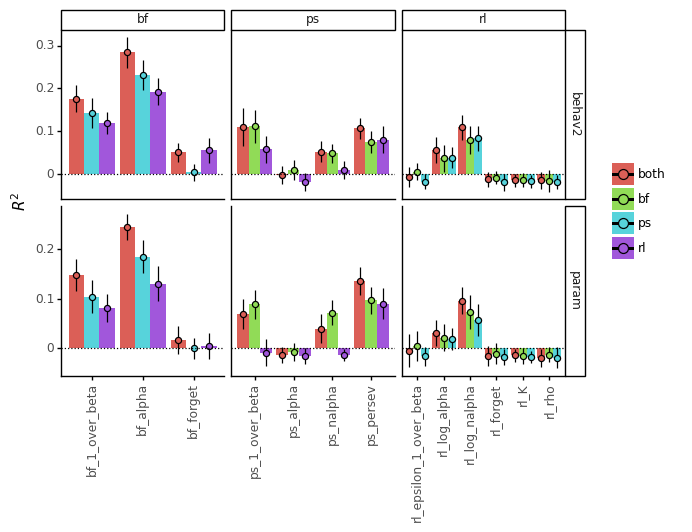

<ggplot: (86293663630)>

In [18]:
gg.options.figure_size = (6.5, 4.5)

# Subset only models in which one task is predicted by one or both others (not by itself)
dat = r2_results.loc[r2_results['param_or_behav'].isin(['param', 'behav2'])]
g = (gg.ggplot(dat, gg.aes('sorted_y_col', 'r2_mean', fill='color'))
     + gg.geom_bar(stat='identity', position=gg.position_dodge(width=0.9))
     + gg.geom_pointrange(gg.aes(ymin='r2_mean-r2_se', ymax='r2_mean+r2_se'), position=gg.position_dodge(width=0.9))
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.labs(x='', fill='', color='', y='$R^2$')
     + gg.facet_grid('param_or_behav ~ y_task', scales='free')
    )
g.save(os.path.join(plot_save_path, '7_RidgeParamParam_r2.png'))
g

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.5 x 4.5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_RidgeParamParam_r2_behav3.png


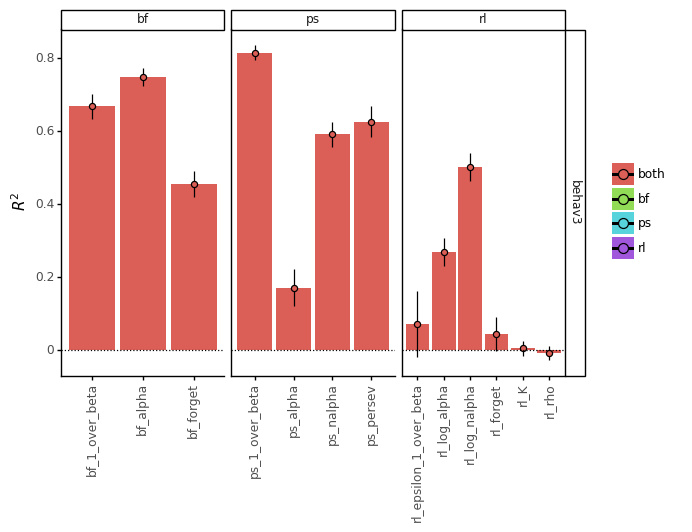

<ggplot: (86293663630)>

In [25]:
g.data = r2_results.loc[
    (r2_results['param_or_behav'] == 'behav3') & (r2_results['color'] == 'both')
]

gg.options.figure_size = (6.5, 2)
g.save(os.path.join(plot_save_path, '7_RidgeParamParam_r2_behav3.png'))
g

### Ridge coefficients

In [17]:
coef_results = pd.read_csv(os.path.join(plot_save_path, 'coef_results_debug_{}.csv'.format(debug)))

In [18]:
coef_results

,Unnamed: 0,param,coef,p,se,model_id,param_or_behav
0,0,rl_log_nalpha,-0.004214,0.965816,0.098238,ps_alpha~ps_,param
1,1,rl_log_alpha,-0.014212,0.890756,0.103366,ps_alpha~ps_,param
2,2,bf_alpha,0.023195,0.788913,0.086542,ps_alpha~ps_,param
3,3,bf_1_over_beta,-0.025109,0.774069,0.087374,ps_alpha~ps_,param
4,4,rl_forget,-0.015390,0.848777,0.080627,ps_alpha~ps_,param
...,...,...,...,...,...,...,...
999,9,rl_LS,-0.065241,0.439949,0.084341,rl_K~rl_,behav3
1000,10,bf_LS,0.008871,0.915818,0.083836,rl_K~rl_,behav3
1001,11,ps_LS,0.001997,0.979239,0.076667,rl_K~rl_,behav3
1002,12,bf_delay,-0.026550,0.724085,0.075125,rl_K~rl_,behav3


In [26]:
coef_results.loc[
#     (['bf_alpha~' in r for r in coef_results['model_id']]) &
    (coef_results['param'] == 'ps_LS') &
    (coef_results['param_or_behav'] == 'behav3')
]

,Unnamed: 0,param,coef,p,se,model_id,param_or_behav
469,11,ps_LS,0.005599,0.934190,0.067740,ps_alpha~ps_,behav3
483,11,ps_LS,0.679417,0.000000,0.044021,ps_persev~ps_,behav3
497,11,ps_LS,-0.714092,0.000000,0.046625,ps_nalpha~ps_,behav3
511,11,ps_LS,0.091131,0.003366,0.030777,ps_1_over_beta~ps_,behav3
525,11,ps_LS,0.081244,0.027258,0.036579,bf_alpha~ps_,behav3
539,11,ps_LS,-0.034579,0.420691,0.042872,bf_1_over_beta~ps_,behav3
553,11,ps_LS,0.065773,0.222999,0.053839,bf_forget~ps_,behav3
567,11,ps_LS,0.072007,0.161135,0.051233,rl_log_nalpha~ps_,behav3
581,11,ps_LS,0.071031,0.267203,0.063874,rl_log_alpha~ps_,behav3
595,11,ps_LS,0.056449,0.446685,0.074063,rl_forget~ps_,behav3


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 20 x 20 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_RidgeParamParam_coefs_param.png


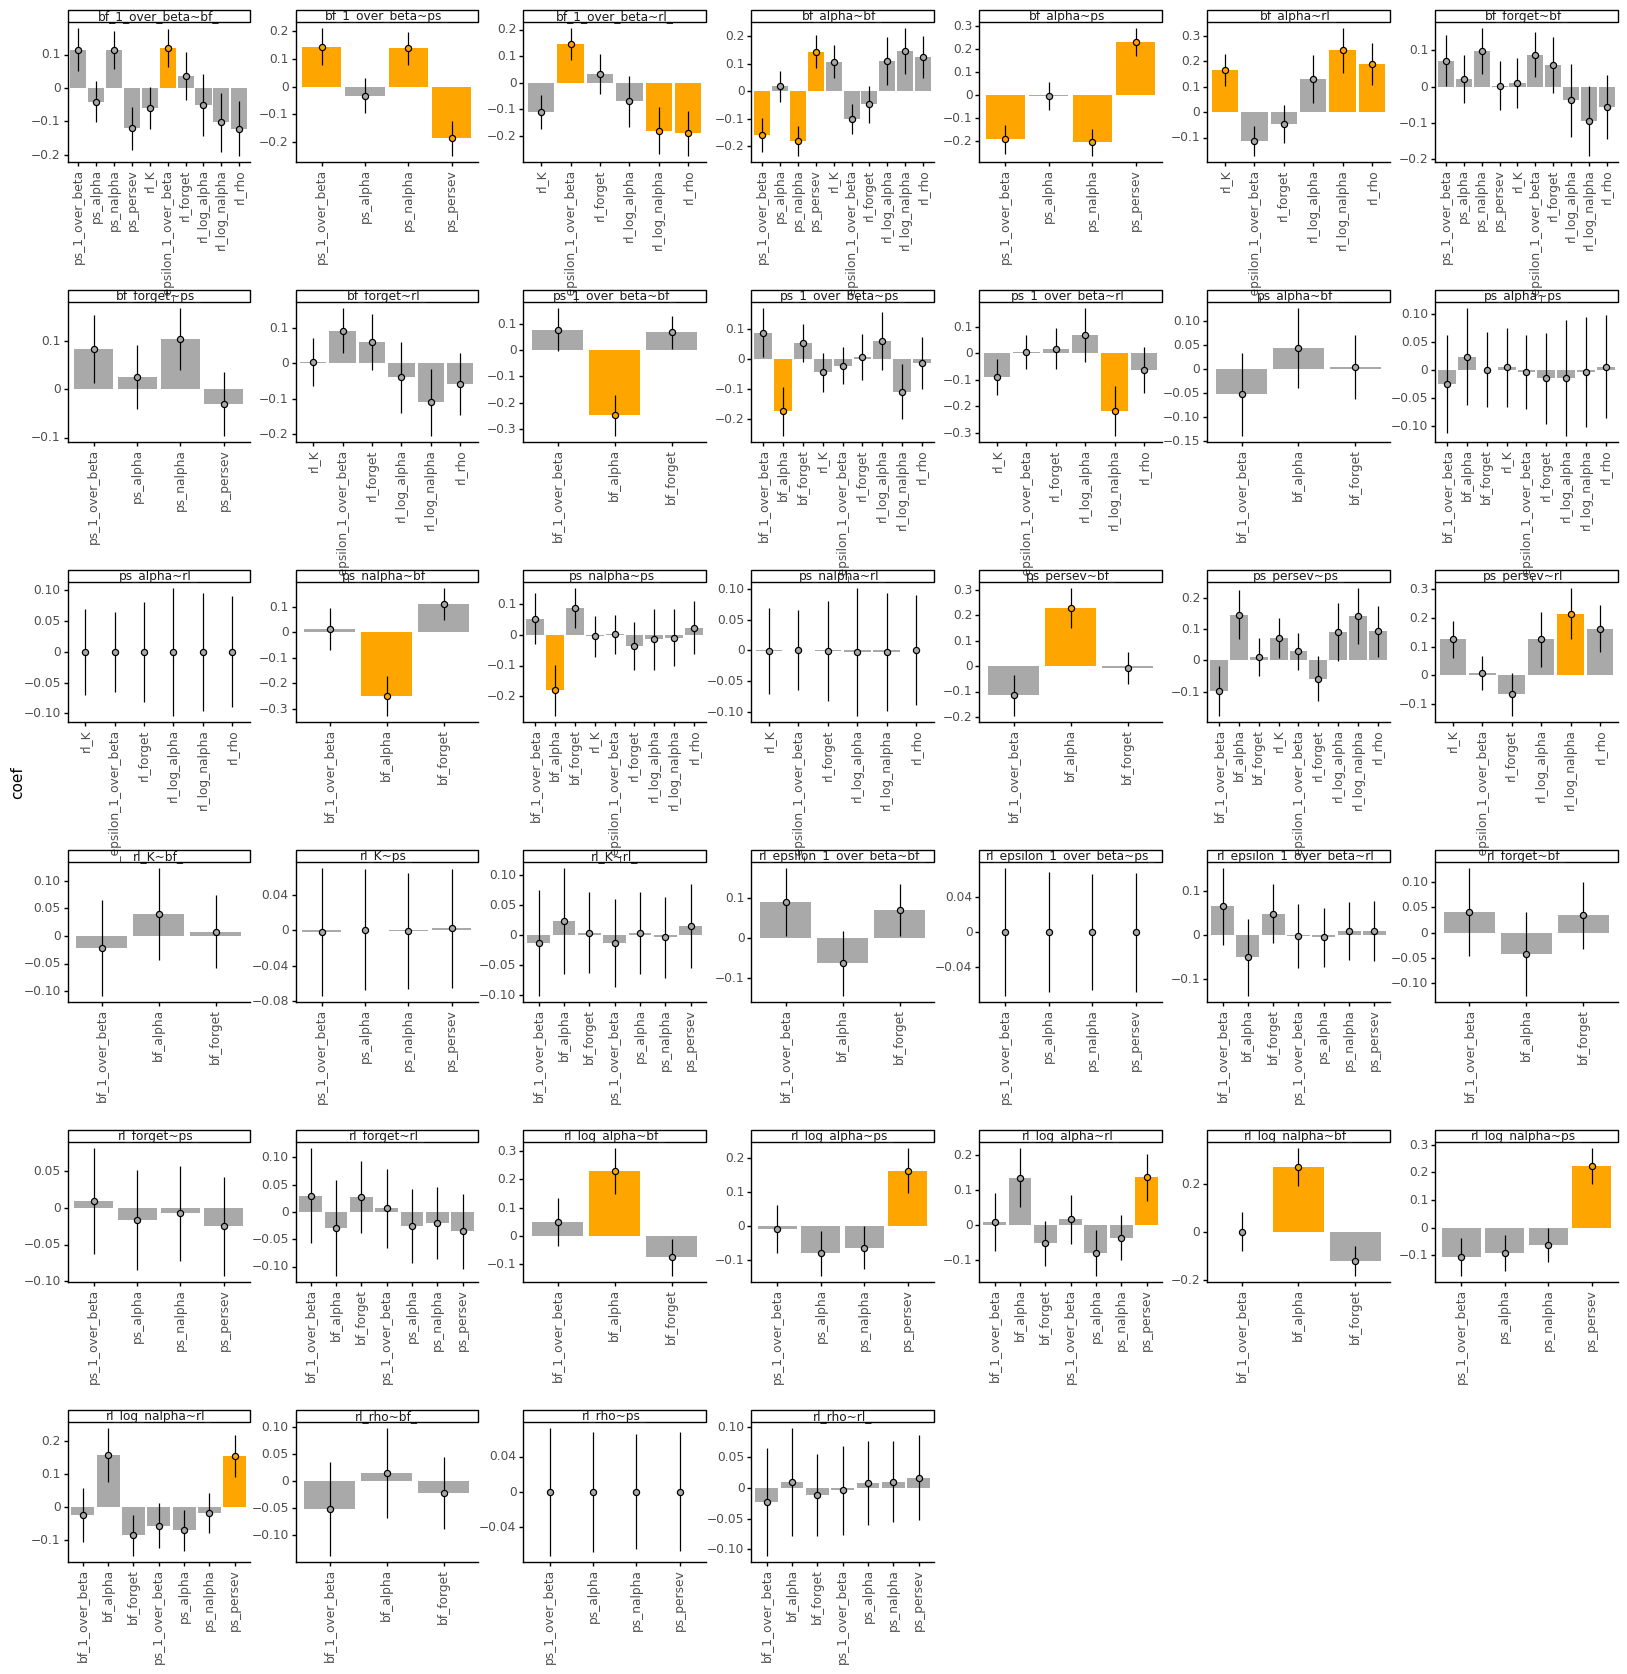

<ggplot: (86293077008)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 20 x 20 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_RidgeParamParam_coefs_behav2.png


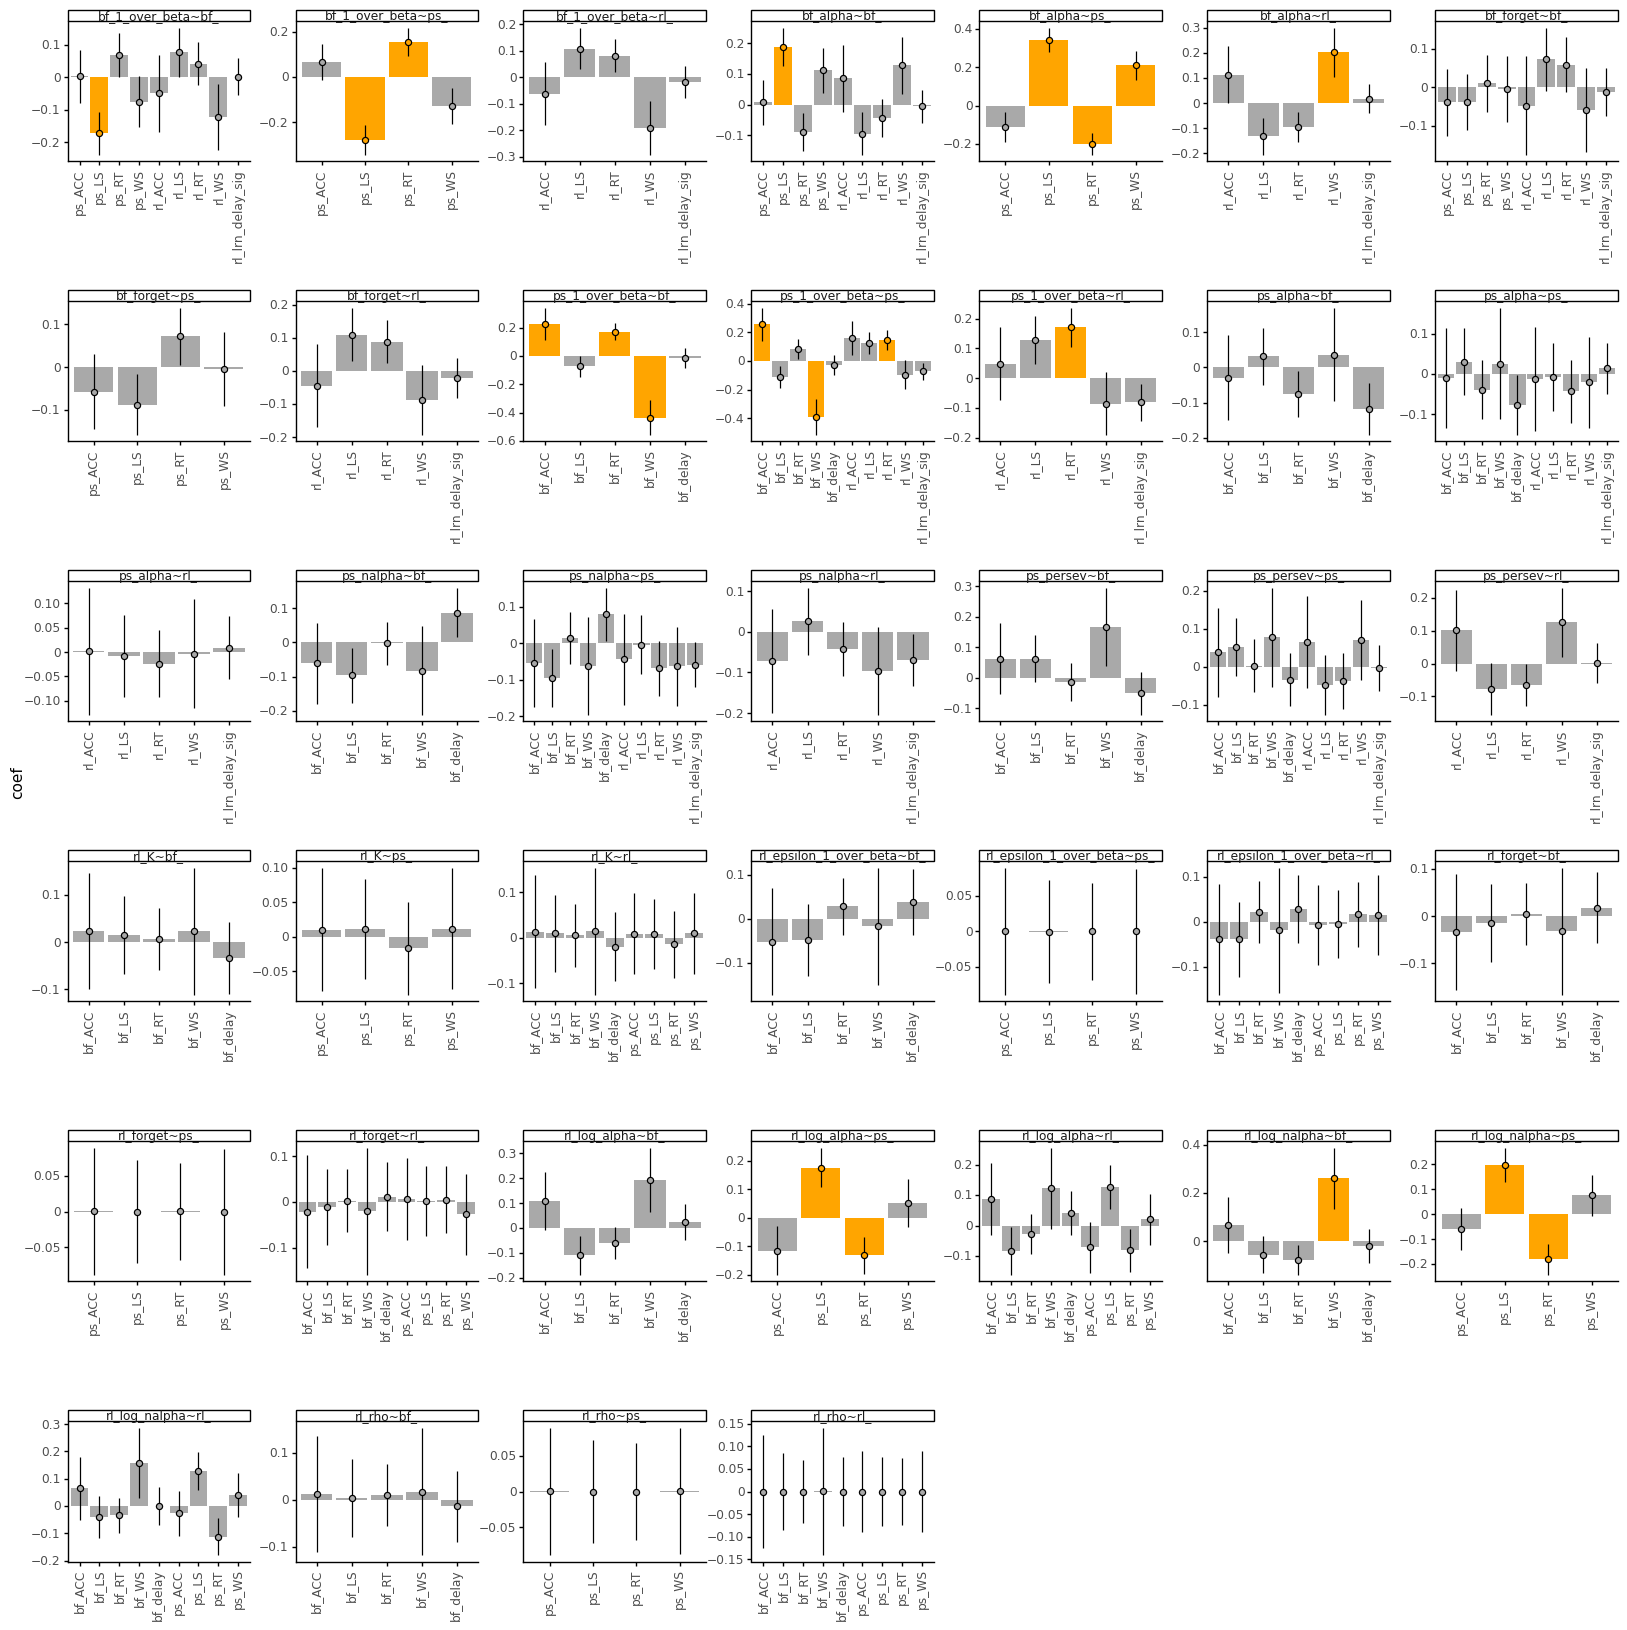

<ggplot: (86298376292)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 20 x 20 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\7_RidgeParamParam_coefs_behav3.png


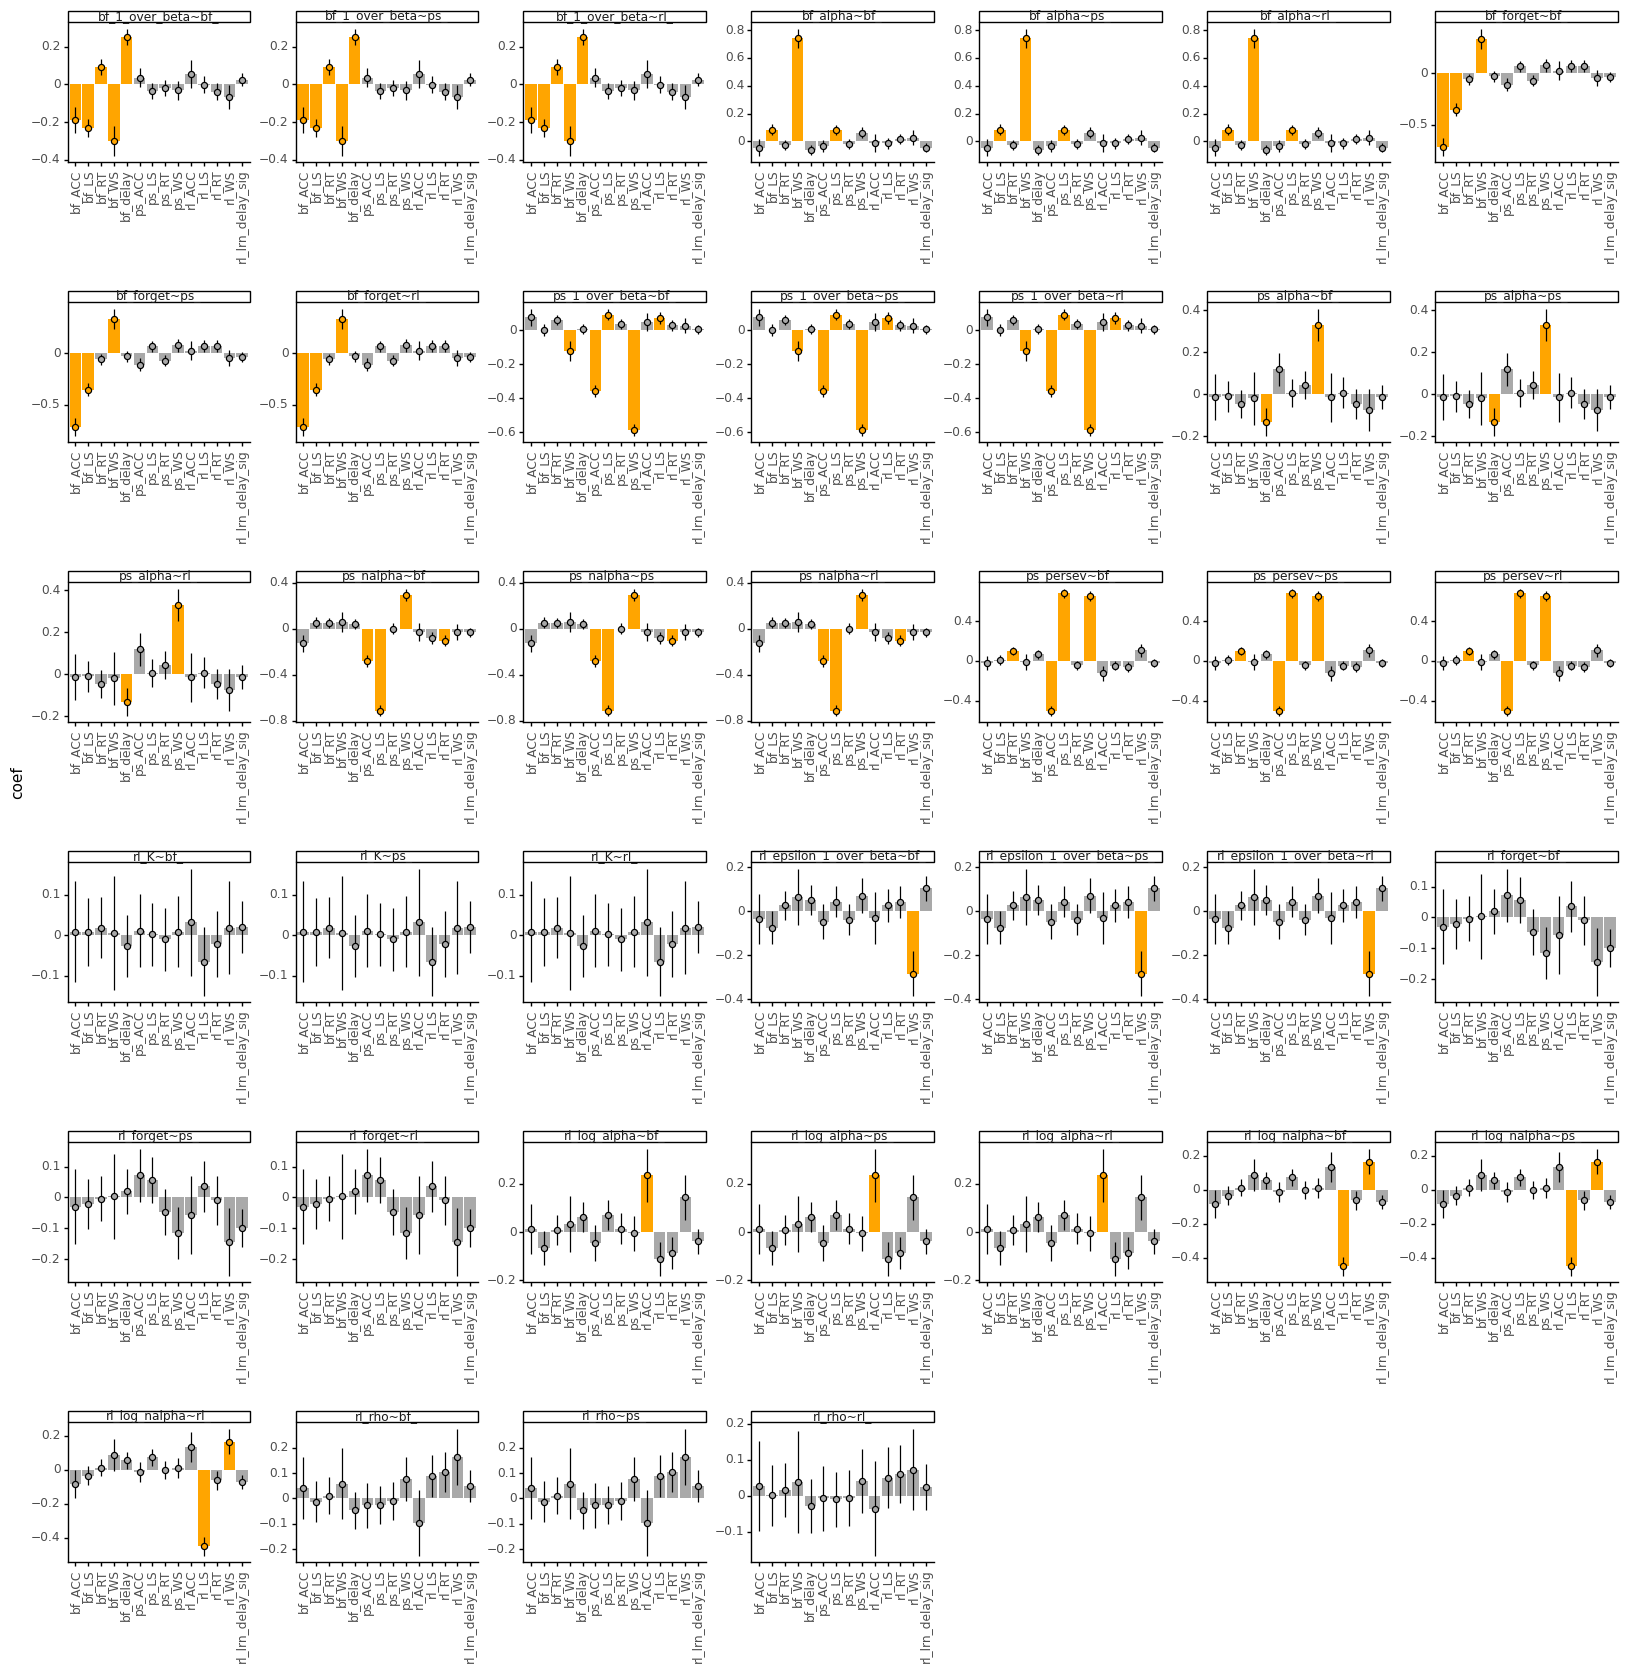

<ggplot: (86295918812)>


In [11]:
for param_or_behav in ['param', 'behav2', 'behav3']:
    
    dat = coef_results.loc[coef_results['param_or_behav'] == param_or_behav]

    gg.options.figure_size = (20, 20)
    g = (gg.ggplot(dat, gg.aes('param', 'coef', fill='p<0.05'))
         + gg.geom_bar(stat='identity')
         + gg.geom_pointrange(gg.aes(ymin='coef-se', ymax='coef+se'), position=gg.position_dodge(width=0.5))
         + gg.scale_fill_manual(['darkgrey', 'orange'])
         + gg.labs(x='', fill='sig.')
         + gg.theme(legend_position='none')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.facet_wrap('~ model_id', scales='free')
         + gg.theme(subplots_adjust={'wspace': 0.25, 'hspace': 1})
        )
    g.save(os.path.join(plot_save_path, '7_RidgeParamParam_coefs_{}.png'.format(param_or_behav)))
    print(g)

In [12]:
raise(ValueError, 'This is the end of the working code. The rest is for historical purposes only.')

TypeError: exceptions must derive from BaseException

# Old stuff

### t-tests

In [17]:
# ttest0 = ttest_1samp(
#     a=r2_results.loc[r2_results['pred_task'] == pred_tasks[0], 'r2'].values[0],
#     popmean=0,
#     axis=0, nan_policy='propagate'
# )

# ttest = ttest_ind_from_stats(
#     mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
#     std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
#     nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
# #                     nobs1=gridder_params['n_repeats'],
#     mean2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2'].values[0],
#     std2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2sd'].values[0],
#     nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
# #                     nobs2=gridder_params['n_repeats'],
#     equal_var=False
# )

# t_row = pd.DataFrame(
#     {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [pred_tasks[1]], 't': [ttest[0]], 'p': [ttest[1]]}
# )
# t_dat_params = t_dat_params.append(t_row)


In [ ]:
# gg.options.figure_size = (6, 3)
# g = (gg.ggplot(best_models_behav, gg.aes('outcome', 'r2', color='pred_task'))
#      + gg.stat_summary(position=gg.position_dodge(width=0.4))
#      + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#      + gg.geom_hline(yintercept=0, linetype='dotted')
#      + gg.labs(x='', color='', y='$R^2$')
#      + gg.facet_grid('~ out_task', scales='free')
#     )
# g

In [ ]:
# Define model for gridder
gridder_params = {
    'model': Ridge(),
    'n_repeats': n_gridder_repeats,
    'n_splitss': np.arange(2, 8),
    'scoring': 'r2',
    'param_grid': {'alpha': [0, 10, 30, 50, 1e2, 3e2, 5e2, 1e3, 3e3, 5e3, 1e4, 1e5, 1e6]},
}

if debug:
    gridder_params['n_repeats'] = 2
    gridder_params['n_splitss'] = [3, 5, ]
    gridder_params['param_grid'] = {'alpha': [0, 50]}

In [ ]:
ridge.best_score_

In [ ]:
{col: coef for col in X_dat.columns for coef in ridge.coef_}

In [ ]:
# Make pretty
gridder_results = make_gridder_pd(gridder)
gridder_results['outcome'] = y_col
gridder_results['X_cols'] = '.'.join(X_dat.columns)
# gridder_results['pred_task'] = predictor_task
gridder_results['n_splits'] = n_splits
gridder_results

In [ ]:
def run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task,
                               regression_type='regular', gridder_params=gridder_params):
    
    # Select regression model
    if regression_type == 'regular':
        mod = sm.OLS(y_dat[y_col], X_dat)
        result = mod.fit()
        
        coef_row = pd.DataFrame({
            'coef': result.params,
            'coef_sd': result.bse,
            'coef_lower': result.conf_int()[0],
            'coef_upper': result.conf_int()[1],
            'p': result.pvalues,
        }).reset_index().rename(columns={'index': 'predictor'})
        coef_row['outcome'] = y_col
        coef_row['pred_task'] = predictor_task
        
        r2_row = pd.DataFrame({
            'r2': [result.rsquared], 'aic': [result.aic],
            'outcome': [y_col], 'pred_task': [predictor_task],
            'r2sd': [0], 'n_splits': [1], 'X_cols': '.'.join(X_dat.columns)
        })
        
    elif regression_type == 'repeatedCV':
        r2_row = pd.DataFrame()
        coefs = pd.DataFrame()

        for i, n_splits in enumerate(gridder_params['n_splitss']):
            
            ### STEP 1: GET R^2
            # Fit regression model
            mod = RepeatableGridSearchCV(
                gridder_params['model'], gridder_params['param_grid'], n_repeats=gridder_params['n_repeats'],
                n_splits=n_splits, scoring=gridder_params['scoring']
            )
            mod.fit(X_dat, y_dat[y_col])

            # Make pretty
            gridder_results = make_gridder_pd(mod)
            gridder_results['outcome'] = y_col
            gridder_results['X_cols'] = '.'.join(X_dat.columns)
            gridder_results['pred_task'] = predictor_task
            gridder_results['n_splits'] = n_splits

            # Append
            r2_row = r2_row.append(gridder_results)
            
            ### STEP 2: GET COEFFICIENTS
            # Fit model
            best_model = gridder_results.loc[gridder_results['mean_test_score'] == np.max(gridder_results['mean_test_score'])]
#             model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#                         regressor=RidgeCV(
#                             alphas=[best_model['param_alpha'].values[0]],
#                             cv=RepeatedKFold(n_splits=n_splits, n_repeats=gridder_params['n_repeats'])),
#             )
            model = Ridge(alpha=[best_model['param_alpha'].values[0]])
            result = model.fit(X_dat, y_dat[y_col])

#             # Get coefficients
#             coef_row = pd.DataFrame(
#                 model.regressor_.coef_, columns=['coef'], index=X_dat.columns
#             ).reset_index().rename(columns={'index': 'predictor'})
            coef_row = pd.DataFrame(
                result.coef_, columns=['coef'], index=X_dat.columns
                ).reset_index().rename(columns={'index': 'predictor'})
            coef_row['p'] = rstats.coef_pval(result, X_dat, y_dat[y_col])[1:]
            coef_row['coef_se'] = rstats.coef_se(result, X_dat, y_dat[y_col])[1:]
            coef_row['outcome'] = y_col
            coef_row['X_cols'] = '.'.join(X_dat.columns)
            coef_row['pred_task'] = predictor_task
            coef_row['n_splits'] = n_splits
            
    return r2_row, coef_row
    
# # Example use
# X_dat = all_data_z[[c for c in param_cols if ('rl_' in c) or ('ps_' in c)]]
# y_col = 'bf_1_over_beta'
# y_dat = all_data_z
# run_regression_get_r2_coef(X_dat, y_dat, y_col, 'blab', regression_type=regression_type)[0]

## Ridge regression / regular regression

### Parameter models

In [ ]:
def run_all_param_regression_models(cols, all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict each parameter from just behavior
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()

    # Predict 1 task from 1 task
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()
    for predictor_task in ['bf_', 'rl_', 'ps_']:
        print('params_' + predictor_task)

        # Get predictor and outcome data
        X_dat = dat[[c for c in cols if predictor_task in c]]
        y_dat = dat[[c for c in cols if predictor_task not in c]]

        for y_col in y_dat.columns:
            
            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_' + predictor_task, regression_type=regression_type)

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])

    # Predict 1 task from the other 2 tasks
    print('params_both')
    for outcome_task in ['bf_', 'rl_', 'ps_']:

        # Get predictor and outcome data
        X_dat = dat[[c for c in cols if outcome_task not in c]]
        y_dat = dat[[c for c in cols if outcome_task in c]]

        for y_col in y_dat.columns:

            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_both', regression_type=regression_type)

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])
        
    return r2_dat, coef_dat

# # Example use
# run_all_param_regression_models(param_cols, all_data_z)

### Behavior models

In [ ]:
def run_all_behav_regression_models(all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict each parameter from just behavior
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()

    for outcome_task in ['bf_', 'rl_', 'ps_']:
        print('behav_' + outcome_task)

        # Get predictor and outcome data
        X_dat = dat[behav_cols]
        y_dat = dat[[c for c in param_cols if outcome_task in c]]

        for y_col in y_dat.columns:

            # Run regression
            r2_row, coef_row = run_regression_get_r2_coef(
                X_dat, y_dat, y_col, 'behav_' + outcome_task, regression_type=regression_type
            )

            # Concat data
            coef_dat = pd.concat([coef_dat, coef_row])
            r2_dat = pd.concat([r2_dat, r2_row])
        
    return r2_dat, coef_dat

# # Example use
# r2_dat, coef_dat = run_all_behav_regression_models(all_data_z)
# r2_dat

In [ ]:
def beautify_coef_r2_df(dat):
    
    # Add and rename columns
    dat['out_task'] = dat['outcome'].apply(lambda x : x[:2])
    dat = dat.rename(columns={'mean_test_score': 'r2', 'std_test_score': 'r2sd'})
    dat['r2se'] = dat.apply(lambda x : x['r2sd'] / np.sqrt(x['n_splits']), axis=1)
    
    # Sort outcome column to plot the points in the right order
    dat['outcome'] = pd.Categorical(dat['outcome'], categories=[
        'bf_1_over_beta', 'bf_alpha', 'bf_forget',
        'ps_1_over_beta','ps_alpha', 'ps_nalpha', 'ps_persev',
        'rl_epsilon_1_over_beta', 'rl_log_alpha', 'rl_log_nalpha', 'rl_forget', 'rl_K', 'rl_rho',
    ])
    dat = dat.reset_index(drop=True)
    
    return dat

# # Example use
# beautify_coef_r2_df(dat)

In [ ]:
save_dir = os.path.join(plot_save_path, 'r2_dat_behav_behav.csv')

if make_boot_models:
    r2_dat_behav, coef_dat_behav = run_all_behav_regression_models(all_data_z)
    r2_dat_behav = beautify_coef_r2_df(r2_dat_behav)

    print('Saving to {}'.format(save_dir))
    r2_dat_behav.to_csv(save_dir)
    
else:
    print('Reading from {}'.format(save_dir))
    r2_dat_behav = pd.read_csv(save_dir)

In [ ]:
best_scores = r2_dat.groupby(['outcome', 'X_cols']).aggregate('max').reset_index()[['outcome', 'X_cols', 'r2', 'r2se']]
best_models_behav = r2_dat.loc[r2_dat['r2'].isin(best_scores['r2'].values)].reset_index(drop=True)
best_models_behav

In [ ]:
best_models_behav.loc[
    (best_models_behav['outcome'] == 'rl_epsilon_1_over_beta')
]

In [ ]:
gg.options.figure_size = (6, 3)
g = (gg.ggplot(best_models_behav, gg.aes('outcome', 'r2', color='pred_task'))
     + gg.stat_summary(position=gg.position_dodge(width=0.4))
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.labs(x='', color='', y='$R^2$')
     + gg.facet_grid('~ out_task', scales='free')
    )
g

In [ ]:
coef_dat_behav['out_cat'] = get_category_from_feature(coef_dat_behav['outcome'], category_dict)
coef_dat_behav

In [ ]:
coef_dat_behav.loc[
    (coef_dat_behav['outcome'].isin(['ps_nalpha', 'rl_log_nalpha']))
]

In [ ]:
for out_cat in np.unique(coef_dat_behav['out_cat']):
    
    sub = coef_dat.loc[coef_dat_behav['out_cat'] == out_cat]

    gg.options.figure_size = (6.5, 2)
    g = (gg.ggplot(sub, gg.aes('predictor', 'coef', fill='p<0.05'))
         + gg.geom_bar(stat='identity')
         + gg.geom_pointrange(gg.aes(ymin='coef-coef_se', ymax='coef+coef_se'))
         + gg.labs(x='', y='Coefficients $\pm$ se')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.scale_fill_manual(['darkgrey', 'orange'])
         + gg.theme(legend_position='none')
         + gg.theme(subplots_adjust={'hspace': 1})
         + gg.facet_wrap('~ outcome', scales='free_x', nrow=1)
        )
    print(g)

In [ ]:
if make_ridge_models:
    r2_dat_params, coef_dat_params = run_all_param_regression_models(param_cols, all_data_z)
    # r2_dat_behav, coef_dat_behav = run_all_param_regression_models(behav_cols, all_data_z)
else:
    r2_dat_params = pd.read_csv(os.path.join(plot_save_path, 'r2_dat_params.csv'), index_col=0)
    coef_dat_params = pd.read_csv(os.path.join(plot_save_path, 'coef_dat_params.csv'), index_col=0)

In [ ]:
# Beautify DataFrames
if make_ridge_models:
    r2_dat_params = beautify_coef_r2_df(r2_dat_params)
#     r2_dat_params = r2_dat_params.rename(columns={'mean_test_score': 'r2', 'std_test_score': 'r2sd'})
#     r2_dat_params['r2se'] = r2_dat_params.apply(lambda x : x['r2sd'] / np.sqrt(x['n_splits']), axis=1)

    save_dir = os.path.join(plot_save_path, 'r2_dat_params.csv')
    print('Saving to {}'.format(save_dir))
    r2_dat_params.to_csv(save_dir)
r2_dat_params

In [ ]:
if make_ridge_models:
    coef_dat_params = beautify_coef_r2_df(coef_dat_params)
    coef_dat_params['out_category'] = get_category_from_feature(coef_dat_params['outcome'], category_dict)
    coef_dat_params['pred_category'] = get_category_from_feature(coef_dat_params['predictor'], category_dict)

    save_dir = os.path.join(plot_save_path, 'coef_dat_params.csv')
    coef_dat_params.to_csv(save_dir)
    print('Saving to {}'.format(save_dir))
coef_dat_params

In [ ]:
best_scores = r2_dat_params.groupby(['outcome', 'X_cols']).aggregate('max').reset_index()[['outcome', 'X_cols', 'r2', 'r2se']]
best_models = r2_dat_params.loc[r2_dat_params['r2'].isin(best_scores['r2'].values)].reset_index(drop=True)
best_models

## Bootstrap results

### Re-run each winning model 1000 times, for bootstrapping

In [ ]:
best_models

In [ ]:
# for _, best_model in best_models.iterrows():
#     model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#                 regressor=RidgeCV(
#                     alphas=[best_model['param_alpha']],
#                     cv=RepeatedKFold(n_splits=n_splits, n_repeats=gridder_params['n_repeats'])),
#     )
#     model.fit(X_dat, y_dat[y_col])

In [ ]:
# n_splits = 20
# mod = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
#             regressor=RidgeCV(
#                 alphas=[best_model['param_alpha']],
#                 cv=RepeatedKFold(n_splits=n_splits, n_repeats=2)),
# )
# mod.fit(X_dat, y_dat[y_col])
# # make_gridder_pd(mod)
# mod.regressor_.coef_
# mod.regressor_.score(X_dat, y_dat[y_col])

In [ ]:
def run_boot_models_r2(best_models, gridder_params, n_boot_models):
    
    boot_models_r2 = pd.DataFrame()

    for row_i, best_model in best_models.iterrows():
        
        print('{} / {} rows'.format(row_i+1, best_models.shape[0]))

        for i in range(n_boot_models):

            # Get gridder_params for this model
            gridder_params_boot = gridder_params.copy()
            gridder_params_boot['n_splitss'] = [best_model['n_splits']]
            gridder_params_boot['n_repeats'] = 2
            gridder_params_boot['param_grid'] = {'alpha': [best_model['param_alpha']]}
            gridder_params_boot

            # Run this model
            X_dat = all_data_z[best_model['X_cols'].split('.')]
            y_col = best_model['outcome']
            y_dat = all_data_z
            r2_row, _ = run_regression_get_r2_coef(
                X_dat, y_dat, y_col, best_model['pred_task'],
                regression_type=regression_type, gridder_params=gridder_params_boot
            )
            r2_row['iteration'] = i

            # Save in big dataframe
            boot_models_r2 = boot_models_r2.append(r2_row)
            
    return boot_models_r2

# # Example use
# run_boot_models_r2(best_models[38:], gridder_params, n_boot_models=2)

In [ ]:
def run_boot_models_coefs(best_models, gridder_params, n_boot_models):
    
    boot_models_coefs = pd.DataFrame()

    for row_i, best_model in best_models.iterrows():
        
        print('{} / {} rows'.format(row_i+1, best_models.shape[0]))

        for i in range(n_boot_models):

            # Get gridder_params for this model
            gridder_params_boot = gridder_params.copy()
            gridder_params_boot['n_splitss'] = [best_model['n_splits']]
            gridder_params_boot['n_repeats'] = 1
            gridder_params_boot['param_grid'] = {'alpha': [best_model['param_alpha']]}
            gridder_params_boot

            # Run this model
            X_dat = all_data_z[best_model['X_cols'].split('.')]
            y_col = best_model['outcome']
            y_dat = all_data_z
            _, coef_row = run_regression_get_r2_coef(
                X_dat, y_dat, y_col, best_model['pred_task'],
                regression_type=regression_type, gridder_params=gridder_params_boot
            )
            coef_row['iteration'] = i

            # Save in big dataframe
            boot_models_coefs = boot_models_coefs.append(coef_row)
            
    return boot_models_coefs

# # Example use
# run_boot_models_coefs(best_models[38:], gridder_params, n_boot_models=2)

In [ ]:
if make_boot_models:
    boot_models_r2 = run_boot_models_r2(best_models, gridder_params, n_boot_models)
    boot_models_coefs = run_boot_models_coefs(best_models, gridder_params, n_boot_models=1)
else:
    boot_models_r2 = pd.read_csv(os.path.join(plot_save_path, 'boot_models_r2 - Copy.csv'), index_col=0)
    boot_models_coefs = pd.read_csv(os.path.join(plot_save_path, 'boot_models_coefs - Copy.csv'), index_col=0)    

In [ ]:
# Beautify DataFrames
if make_boot_models:
    boot_models_r2 = beautify_coef_r2_df(boot_models_r2)
    boot_models_r2 = boot_models_r2.rename(columns={'mean_test_score': 'r2', 'std_test_score': 'r2sd'})
    boot_models_r2['r2se'] = boot_models_r2.apply(lambda x : x['r2sd'] / np.sqrt(x['n_splits']), axis=1)
boot_models_r2

In [ ]:
if make_boot_models:
    boot_models_coefs = beautify_coef_r2_df(boot_models_coefs)
    boot_models_coefs['out_category'] = get_category_from_feature(boot_models_coefs['outcome'], category_dict)
    boot_models_coefs['pred_category'] = get_category_from_feature(boot_models_coefs['predictor'], category_dict)
boot_models_coefs

In [ ]:
if make_boot_models:
    save_dir = os.path.join(plot_save_path, 'boot_models_r2_nit_{}.csv'.format(n_boot_models))
    boot_models_r2.to_csv(save_dir)
    print('Saving to {}'.format(save_dir))
    save_dir = os.path.join(plot_save_path, 'boot_models_coefs_nit_{}.csv'.format(n_boot_models))
    boot_models_coefs.to_csv(save_dir)
    print('Saving to {}'.format(save_dir))    

### Calculate stats of interest on these models

In [ ]:
boot_models_r2['r2<0'] = (boot_models_r2['r2'] < 0).astype(int)
boot_models_coefs['coef<0'] = (boot_models_coefs['coef'] < 0).astype(int)

In [ ]:
gg.options.figure_size = (6, 3)
g = (gg.ggplot(boot_models_r2, gg.aes('outcome', 'r2', color='pred_task'))
     + gg.stat_summary(position=gg.position_dodge(width=0.4))
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.geom_hline(yintercept=0, linetype='dotted')
     + gg.labs(x='', color='', y='$R^2$')
     + gg.facet_grid('~ out_task', scales='free')
    )
g

In [ ]:
id_cols = ['X_cols', 'pred_task', 'outcome']
# summarize, calculate means, sd, and p-values
boot_models_r2_sum = boot_models_r2[id_cols + ['r2', 'r2<0']].groupby(id_cols).aggregate(['mean', 'std']).reset_index()
# flatten hierarchical columns
boot_models_r2_sum.columns = [
    high + low for high, low in
    zip(boot_models_r2_sum.columns.get_level_values(0), boot_models_r2_sum.columns.get_level_values(1))
]
# add out_task column
boot_models_r2_sum['out_task'] = boot_models_r2_sum['outcome'].apply(lambda x : x[:2])
boot_models_r2_sum

In [ ]:
boot_models_coefs.loc[
    (boot_models_coefs['outcome'] == 'ps_nalpha') & (boot_models_coefs['pred_task'] == 'params_bf_')
]

## Plots

## Old t-tests

In [ ]:
t_dat_params = pd.DataFrame()

# param_pred_tasks = ['both_params_and_age', 'ps_params_and_age', 'rl_params_and_age', 'bf_params_and_age']
param_pred_tasks = ['params_both', 'params_ps_', 'params_rl_', 'params_bf_']

for out_task in ['ps', 'bf', 'rl']:
    
    pre_dat = best_models.loc[
        (best_models['out_task'] == out_task) &
        (best_models['pred_task'].isin(param_pred_tasks))
    ]
    
    for outcome in np.unique(pre_dat['outcome']):
        dat = pre_dat.loc[pre_dat['outcome'] == outcome]

        for pred_task in param_pred_tasks:
            try:
                # Compare one task's R2 against 0
#                 ttest0 = ttest_ind_from_stats(
#                     mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
#                     std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
#                     nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
#                     mean2=0,
#                     std2=0,
#                     nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
#                     equal_var=False
#                 )
#                 t_row = pd.DataFrame(
#                     {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [np.nan], 't': [ttest0[0]], 'p': [ttest0[1]]}
#                 )
#                 t_dat_params = t_dat_params.append(t_row)

                x_bar = dat.loc[dat['pred_task'] == pred_task, 'r2'].values[0]
                mu = 0
                sd = dat.loc[dat['pred_task'] == pred_task, 'r2sd'].values[0]
                n = dat.loc[dat['pred_task'] == pred_task, 'n_splits'].values[0]  # df based on n_splits
#                 n = gridder_params['n_repeats']  # df based on n_repeats
                
                t = (x_bar - mu) * np.sqrt(n) / sd
                p = sstats.t.pdf(x=t, df=n - 1)

                t_row = pd.DataFrame(
                    {'outcome': [outcome], 'pred_task0': [pred_task], 'pred_task1': [np.nan], 't': [t], 'p': [p]}
                )
                t_dat_params = t_dat_params.append(t_row)
                
            except IndexError:  # When one task does not exist in the dataframe because it is the predicted one
                pass
        
        for pred_tasks in itertools.combinations(param_pred_tasks, 2):
            
            # Compare two tasks' R2's against each other
            try:
                ttest = ttest_ind_from_stats(
                    mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
                    std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
                    nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
#                     nobs1=gridder_params['n_repeats'],
                    mean2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2'].values[0],
                    std2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2sd'].values[0],
                    nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
#                     nobs2=gridder_params['n_repeats'],
                    equal_var=False
                )
                t_row = pd.DataFrame(
                    {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [pred_tasks[1]], 't': [ttest[0]], 'p': [ttest[1]]}
                )
                t_dat_params = t_dat_params.append(t_row)

            except IndexError:  # When one task does not exist in the dataframe because it is the predicted one
                pass

t_dat_params = t_dat_params.reset_index(drop=True)
t_dat_params['sig'] = t_dat_params[['t', 'p']].apply(lambda x: '*' if (x[1] < 0.05) & (x[0] > 0) else '', axis=1)
t_dat_params[:41]

In [ ]:
t_dat_behav = pd.DataFrame()

# behav_pred_tasks = ['both_behav_and_age', 'behav_ps_age', 'behav_rl_age', 'behav_bf_age']
behav_pred_tasks = ['behav_both', 'behav_ps_', 'behav_rl_', 'behav_bf_']

for out_task in ['ps', 'bf', 'rl']:
    
    pre_dat = best_models.loc[
        (best_models['out_task'] == out_task) &
        (best_models['pred_task'].isin(behav_pred_tasks))
    ]
    
    for outcome in np.unique(pre_dat['outcome']):
        dat = pre_dat.loc[pre_dat['outcome'] == outcome]

        for pred_tasks in itertools.combinations(behav_pred_tasks, 2):

#             # Compare one task's R2 against 0
#             ttest0 = ttest_1samp(
#                 a=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
#                 popmean=0,
#                 axis=0, nan_policy='propagate'
#             )
#             t_row = pd.DataFrame(
#                 {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [np.nan], 't': [ttest[0]], 'p': [ttest[1]]}
#             )
#             t_dat_behav = t_dat_behav.append(t_row)

            # Compare two tasks' R2's against each other
            try:
                ttest = ttest_ind_from_stats(
                    mean1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2'].values[0],
                    std1=dat.loc[dat['pred_task'] == pred_tasks[0], 'r2sd'].values[0],
                    nobs1=dat.loc[dat['pred_task'] == pred_tasks[0], 'n_splits'].values[0],
                    mean2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2'].values[0],
                    std2=dat.loc[dat['pred_task'] == pred_tasks[1], 'r2sd'].values[0],
                    nobs2=dat.loc[dat['pred_task'] == pred_tasks[1], 'n_splits'].values[0],
                    equal_var=False
                )
                t_row = pd.DataFrame(
                    {'outcome': [outcome], 'pred_task0': [pred_tasks[0]], 'pred_task1': [pred_tasks[1]], 't': [ttest[0]], 'p': [ttest[1]]}
                )
                t_dat_behav = t_dat_behav.append(t_row)

            except IndexError:  # When one task does not exist in the dataframe because it is the predicted one
                pass

t_dat_behav = t_dat_behav.reset_index(drop=True)
t_dat_behav

In [ ]:
inverse_pred_tasks = ['inverse_behav_{}'.format(t) for t in ['bf_', 'rl_', 'ps_']]
inverse_pred_tasks

## Plots

In [ ]:
def get_aic_plot_subdat(best_models, categories, y):
    
    sub_dat = best_models.loc[best_models['pred_task'].isin(categories)]
    sub_dat['pred_task'] = pd.Categorical(sub_dat['pred_task'], categories=categories)
    if 'null_model' in best_models['pred_task']:
        null_model_aic = best_models.loc[best_models['pred_task'] == 'null_model', y].values[0]
        sub_dat['null_minus_model_{}'.format(y)] = null_model_aic - sub_dat[y]
    else:
        sub_dat['null_minus_model_{}'.format(y)] = 0

    return sub_dat

# # Example use
# get_aic_plot_subdat(best_models, categories, y='r2')

In [ ]:
# categories=['both_params_and_age', 'both_behav_and_age', 'both_params_behav_age']
sub_dat = best_models.loc[best_models['pred_task'].isin(param_pred_tasks)]
sub_dat

In [ ]:
# Get name of y-axis
if regression_type == 'repeatedCV':
    y = 'r2'
elif regression_type == 'regular':
    y = 'aic'
    
# Get data
sub_dat = get_aic_plot_subdat(
    best_models,
    categories=['both_params_and_age', 'both_behav_and_age', 'both_params_behav_age'],
    y=y
)

# Plot absolute aics
gg.options.figure_size = (5, 2)
g_aic = (gg.ggplot(sub_dat, gg.aes('outcome', y, color='pred_task'))
         + gg.geom_point(position=gg.position_dodge(width=0.5))
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.labs(x='')
         + gg.facet_wrap('~ out_task', scales='free_x')
        )
if regression_type == 'repeatedCV':
    
    g_aic_ = g_aic
    g_aic = (g_aic_
             + gg.geom_pointrange(gg.aes(ymin='r2-r2se', ymax='r2+r2se'), position=gg.position_dodge(width=0.5))
             + gg.geom_hline(yintercept=0, linetype='dotted')
            )

# Predicting parameters from behaviors
g_aic.data = get_aic_plot_subdat(
    best_models,
    categories=behav_pred_tasks,
    y=y
)
print(g_aic)
g_aic.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}.png'.format(y, regression_type)))

g_ns = g_aic + gg.aes(y='n_splits')
g_ns.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}_nsplits.png'.format(y, regression_type)))

g_a = g_aic + gg.aes(y='param_alpha')
g_a.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}_alpha.png'.format(y, regression_type)))

# Predicting parameters from parameters
g_aic.data = get_aic_plot_subdat(
    best_models,
    categories=param_pred_tasks,
    y=y
)
print(g_aic)
g_aic.save(os.path.join(plot_save_path, '4_PredictParamByParams_{}_{}.png'.format(y, regression_type)))

# Predicting behaviors from parameters
g_aic.data = get_aic_plot_subdat(
    best_models,
    categories=inverse_pred_tasks,
    y=y
)
print(g_aic)
g_aic.save(os.path.join(plot_save_path, '4_PredictBehavrByParams_{}_{}.png'.format(y, regression_type)))

## Get coefficients

In [ ]:
coef_dat_params.loc[(coef_dat_params['pred_task'] == 'both_behav_and_age') & (coef_dat_params['outcome'] == 'rl_epsilon_1_over_beta')]
# coef_dat_params.loc[(coef_dat_params['pred_task'] == 'both_and_age') & (coef_dat_params['outcome'] == 'ps_alpha')]

In [ ]:
coef_dat_params.loc[
    (coef_dat_params['outcome'] == 'bf_1_over_beta') & (coef_dat_params['pred_task'].isin(param_pred_tasks))
]

In [ ]:
def plot_coef(coef_dat, subset_pred_task, hspace=0):

    # Subset model with both tasks only (individual tasks are very similar)
    sub = coef_dat.loc[coef_dat['pred_task'] == subset_pred_task]

    return (gg.ggplot(sub, gg.aes('predictor', 'coef', fill='p<0.05'))
         + gg.geom_bar(stat='identity')
         + gg.geom_pointrange(gg.aes(ymin='coef-coef_se', ymax='coef+coef_se'))
         + gg.labs(x='', y='Coefficients +- se')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.scale_fill_manual(['darkgrey', 'orange'])
         + gg.theme(legend_position=(0.8, 0.2))
         + gg.theme(subplots_adjust={'hspace': hspace})
         + gg.facet_wrap('~ outcome', scales='free_x')
        )

# Use
gg.options.figure_size = (9, 12)

for pred_task in param_pred_tasks + behav_pred_tasks + inverse_pred_tasks:
# for pred_task in inverse_pred_tasks:
    print(pred_task)
    g_p = plot_coef(coef_dat_params, subset_pred_task=pred_task, hspace=1.2)
    print(g_p)
    g_p.save(os.path.join(plot_save_path, '4_Coefs{}.png'.format(pred_task)), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='both_params_and_age', hspace=1.2)
# print(g_p)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_param_both_and_age.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='both_behav_and_age', hspace=0.6)
# print(g_p)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_both_behav_and_age.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='params_both', hspace=1.2)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_param_both.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='behav_both', hspace=0.6)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_behav_both.png'), limitsize=False)

# g_p = plot_coef(coef_dat_params, subset_pred_task='both_params_behav_age', hspace=1.2)
# print(g_p)
# g_p.save(os.path.join(plot_save_path, '4_PredictParamsByParams_coef_param_behav_both_and_age.png'), limitsize=False)

## run_all_old_regression_models

In [ ]:
def run_all_old_regression_models(cols, all_data_z):

    # Set up empty DataFrames
    coef_dat = pd.DataFrame()
    r2_dat = pd.DataFrame()

    # Predict each parameter from just behavior
    dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()

#     # Get predictor and outcome data
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('behav_' + predictor_task)

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols if predictor_task in c]]
#         y_dat = dat[[c for c in cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'behav_' + predictor_task, regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Get predictor and outcome data
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('inverse_behav_' + predictor_task)

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in param_cols if predictor_task in c]]
#         y_dat = dat[[c for c in behav_cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'inverse_behav_' + predictor_task, regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Get predictor and outcome data
#     print('behav_both')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'behav_both', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Predict 1 task from 1 task
#     dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols]].dropna()
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('params_' + predictor_task)

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols if predictor_task in c]]
#         y_dat = dat[[c for c in cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_' + predictor_task, regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Predict 1 task from the other 2 tasks
#     print('params_both')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'params_both', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Age models
#     dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols] + ['PreciseYrs']].dropna()
#     dat['PreciseYrs2'] = np.square(dat['PreciseYrs'])
    
#     # Predict 1 task from the other 2 tasks + age
#     print('both_behav_and_age')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols + ['PreciseYrs', 'PreciseYrs2'] if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both_behav_and_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])
            
#     # Predict 1 task from the other 2 tasks behaviors + age
#     print('both_params_and_age')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols + ['PreciseYrs', 'PreciseYrs2'] if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both_params_and_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])
            
#     # Predict 1 task from the other 2 tasks behaviors + age
#     print('both_params_behav_age')
#     for outcome_task in ['bf_', 'rl_', 'ps_']:

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols + behav_cols + ['PreciseYrs', 'PreciseYrs2'] if outcome_task not in c]]
#         y_dat = dat[[c for c in cols if outcome_task in c]]

#         for y_col in y_dat.columns:

#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'both_params_behav_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])
            
#     # Predict 1 task from 1 task + age
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('1task_params_and_age')

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in cols if predictor_task in c] + ['PreciseYrs', 'PreciseYrs2']]
#         y_dat = dat[[c for c in cols if predictor_task not in c]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, predictor_task + 'params_and_age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Get predictor and outcome data
#     for predictor_task in ['bf_', 'rl_', 'ps_']:
#         print('behav_' + predictor_task + 'age')

#         # Get predictor and outcome data
#         X_dat = dat[[c for c in behav_cols if predictor_task in c] + ['PreciseYrs', 'PreciseYrs2']]
#         y_dat = dat[[c for c in cols if (predictor_task not in c) and ('PreciseYrs' not in c)]]

#         for y_col in y_dat.columns:
            
#             # Run regression
#             r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'behav_' + predictor_task + 'age', regression_type=regression_type)

#             # Concat data
#             coef_dat = pd.concat([coef_dat, coef_row])
#             r2_dat = pd.concat([r2_dat, r2_row])

#     # Predict each parameter from just age
#     print('just_age')

#     # Get predictor and outcome data
#     X_dat = dat[['PreciseYrs', 'PreciseYrs2']]
#     y_dat = dat[cols]

#     for y_col in y_dat.columns:

#         # Run regression
#         r2_row, coef_row = run_regression_get_r2_coef(X_dat, y_dat, y_col, 'just_age', regression_type=regression_type)

#         # Concat data
#         coef_dat = pd.concat([coef_dat, coef_row])
#         r2_dat = pd.concat([r2_dat, r2_row])
        
#     return r2_dat, coef_dat

# # Example use
# run_all_old_regression_models(param_cols, all_data_z)